In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import statsmodels.api as sm
import os
from glob import glob
from twolyr_cmip.model import Model
from twolyr_cmip.twolyr import TwoLayerModel
from twolyr_cmip.cesm_functions import fixmonth
from scipy.stats import linregress
import cftime
from pathlib import Path

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 10

In [2]:
experiments = ["piControl", "abrupt-4xCO2"]

variables = ["tas", "rsdt", "rsut", "rlut"]

models = ["ACCESS-ESM1-5",
          "CanESM5",
          "CESM2",
          "EC-Earth3",
          "CNRM-CM6-1",
          "GISS-E2-1-G",
          "GISS-E2-1-H",
          "INM-CM5-0",
          "IPSL-CM6A-LR",
          "MIROC6",
          "MIROC-ES2L",
          "MPI-ESM1-2-LR",
          "MPI-ESM1-2-HR",
          "MRI-ESM2-0",
          "NorCPM1",
          "UKESM1-0-LL"]

In [3]:
def globmean(da):
    return da.weighted(np.cos(np.deg2rad(da.lat))).mean(("lat", "lon"))

In [4]:
droot = Path("../data/processed")
ddict = {}

yrs = np.arange(150)

for name in models:
    print(f"Model = {name}")
    ddict[name] = {}
    for exp in experiments:
        print(f"\t Experiment: {exp}")
        ddict[name][exp] = {}
        ddir = droot.joinpath(name, exp)
        for var in variables:
            dfile = f"{var}_{name}_{exp}_ens_tseries_185001-199912.nc"
            ncf = os.path.join(ddir, dfile)
            ds = xr.open_dataset(ncf)

            if "ensmem" in ds.dims and ds.ensmem.size > 1:
                da = ds[var].isel(ensmem=0).squeeze()
            else:
                da = ds[var].squeeze()
            
            da = da.expand_dims("ensmem").groupby("time.year").mean("time")
            da = da.assign_coords({"year": ("year", yrs),
                                   "ensmem": ("ensmem", ["r1i1p1f1"])})
            ddict[name][exp][var] = da

Model = ACCESS-ESM1-5
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = CanESM5
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = CESM2
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = EC-Earth3
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = CNRM-CM6-1
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = GISS-E2-1-G
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = GISS-E2-1-H
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = INM-CM5-0
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = IPSL-CM6A-LR
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = MIROC6
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = MIROC-ES2L
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = MPI-ESM1-2-LR
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = MPI-ESM1-2-HR
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = MRI-ESM2-0
	 Experiment: piControl
	 Experiment: abrupt-4xCO2
Model = NorCPM1
	 Exp

In [5]:
for name in models:
    for exp in experiments:
        ddict[name][exp]["rtmt"] = ddict[name][exp]["rsdt"] - \
            ddict[name][exp]["rsut"] - ddict[name][exp]["rlut"]

In [6]:
ddir = "../data/forcingdata"
nc_c = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.69.nonudge_novolc_icefix.cam.h0.globavg.nc")
nc_v = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.70.nonudge_volc_icefix.cam.h0.globavg.nc")

ds_c = xr.open_dataset(nc_c)
ds_v = xr.open_dataset(nc_v)

time = ds_c.time.data
timetmp = [pd.to_datetime(t) for t in time]
timenew = [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in timetmp]

ds_c = fixmonth(ds_c.assign_coords({"time": ("time", timenew)}))
ds_v = fixmonth(ds_v.assign_coords({"time": ("time", timenew)}))

ds_c = ds_c.sel(time=slice("1985-01", "2004-12"))
ds_v = ds_v.sel(time=slice("1985-01", "2004-12"))

toa_c = ds_c["FSNT"] - ds_c["FLNT"]
toa_v = ds_v["FSNT"] - ds_v["FLNT"]

F_sw = ds_v["FSNT"] - ds_c["FSNT"]

F = toa_v - toa_c

### Fit and solve model for both 4xCO2 and Volcano

In [7]:
T1_4x_dict = {}
T2_4x_dict = {}

T1_volc_dict = {}
T2_volc_dict = {}

SW_dict = {}

T1_sum = {}
SW_sum = {}

ratio = {}
Ndict = {}
N_4x_dict = {}
Nint_dict = {}

param_dict = {}

model_eff = "variable"

timevec = pd.date_range("1985-01", "2004-12", freq="MS")

F_sw = F_sw.assign_coords({"time": ("time", timevec)})
F = F.assign_coords({"time": ("time", timevec)})

for name in models:
    print(f"Model: {name}")
    T = ddict[name]["abrupt-4xCO2"]["tas"] - ddict[name]["piControl"]["tas"]
    N = ddict[name]["abrupt-4xCO2"]["rtmt"] - ddict[name]["piControl"]["rtmt"]
    SW1 = ddict[name]["piControl"]["rsdt"] - ddict[name]["piControl"]["rsut"]
    SW2 = ddict[name]["abrupt-4xCO2"]["rsdt"] - ddict[name]["abrupt-4xCO2"]["rsut"]
    SW = SW2 - SW1    
    
    twolayer = TwoLayerModel(model_epsilon=model_eff, verbose=False)
    
    twolayer.fit_params(T, N)
    twolayer.fit_lambda_sw(T, SW)
    
    T1_4x, T2_4x = twolayer.solve_model()
    param_dict[name] = twolayer.params
    
    T1_4x_dict[name] = T1_4x.interp(time=np.arange(150))
    T2_4x_dict[name] = T2_4x.interp(time=np.arange(150))
    
    N_4x_dict[name] = -param_dict[name]["lam"]*T1_4x_dict[name] + param_dict[name]["F_ref"] + \
        param_dict[name]["gamma"]*(param_dict[name]["epsilon"]-1)*(T2_4x_dict[name]-T1_4x_dict[name])
    
    T1_volc, T2_volc = twolayer.solve_model(forcing=F, tstep=1/12)
    
    T1_volc = T1_volc.interp(time=np.arange(240))
    T2_volc = T2_volc.interp(time=np.arange(240))
    
    T1_volc_dict[name] = T1_volc.assign_coords({"time": ("time", timevec)}) 
    T2_volc_dict[name] = T2_volc.assign_coords({"time": ("time", timevec)}) 
    
    SW_dict[name] = F_sw - param_dict[name]["lam_sw"]*T1_volc_dict[name]
    
    T1_sum[name] = T1_volc_dict[name].sel(time=slice("1991-06", "1996-05")).sum("time")
    SW_sum[name] = SW_dict[name].sel(time=slice("1991-06", "1993-05")).sum("time")
    ratio[name] = T1_sum[name]/SW_sum[name]
    
    Ndict[name] = -param_dict[name]["lam"]*T1_volc_dict[name] + F + \
        param_dict[name]["gamma"]*(param_dict[name]["epsilon"]-1)*(T2_volc_dict[name]-T1_volc_dict[name])
    
    Nint_dict[name] = Ndict[name].sel(time=slice("1991-06", "1993-05")).sum()
    
    print(twolayer)
    print("")

Model: ACCESS-ESM1-5
TwoLayerModel
---Parameters---
F: [6.58735549]
lambda: [0.69568514]
T_eq: [9.46887487]
gamma: [0.95963977]
epsilon: [1.36197033]

Model: CanESM5
TwoLayerModel
---Parameters---
F: [7.45190045]
lambda: [0.64401129]
T_eq: [11.5710712]
gamma: [0.55167861]
epsilon: [1.0605855]

Model: CESM2
TwoLayerModel
---Parameters---
F: [8.09657341]
lambda: [0.64369747]
T_eq: [12.57822781]
gamma: [0.94636828]
epsilon: [1.3851232]

Model: EC-Earth3
TwoLayerModel
---Parameters---
F: [7.54973565]
lambda: [0.85326737]
T_eq: [8.84803043]
gamma: [0.80843742]
epsilon: [1.29293322]

Model: CNRM-CM6-1
TwoLayerModel
---Parameters---
F: [7.30930045]
lambda: [0.75121717]
T_eq: [9.72994324]
gamma: [0.49771468]
epsilon: [0.99142669]

Model: GISS-E2-1-G
TwoLayerModel
---Parameters---
F: [8.49156754]
lambda: [1.63665164]
T_eq: [5.18837812]
gamma: [0.83969728]
epsilon: [0.96785547]

Model: GISS-E2-1-H
TwoLayerModel
---Parameters---
F: [7.25941579]
lambda: [1.13248893]
T_eq: [6.41014286]
gamma: [0.68

In [8]:
colors = pl.cm.tab20.colors

### Plot 4xCO2 data vs two-layer model output

ACCESS-ESM1-5
CanESM5
CESM2
EC-Earth3
CNRM-CM6-1
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MIROC-ES2L
MPI-ESM1-2-LR
MPI-ESM1-2-HR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL


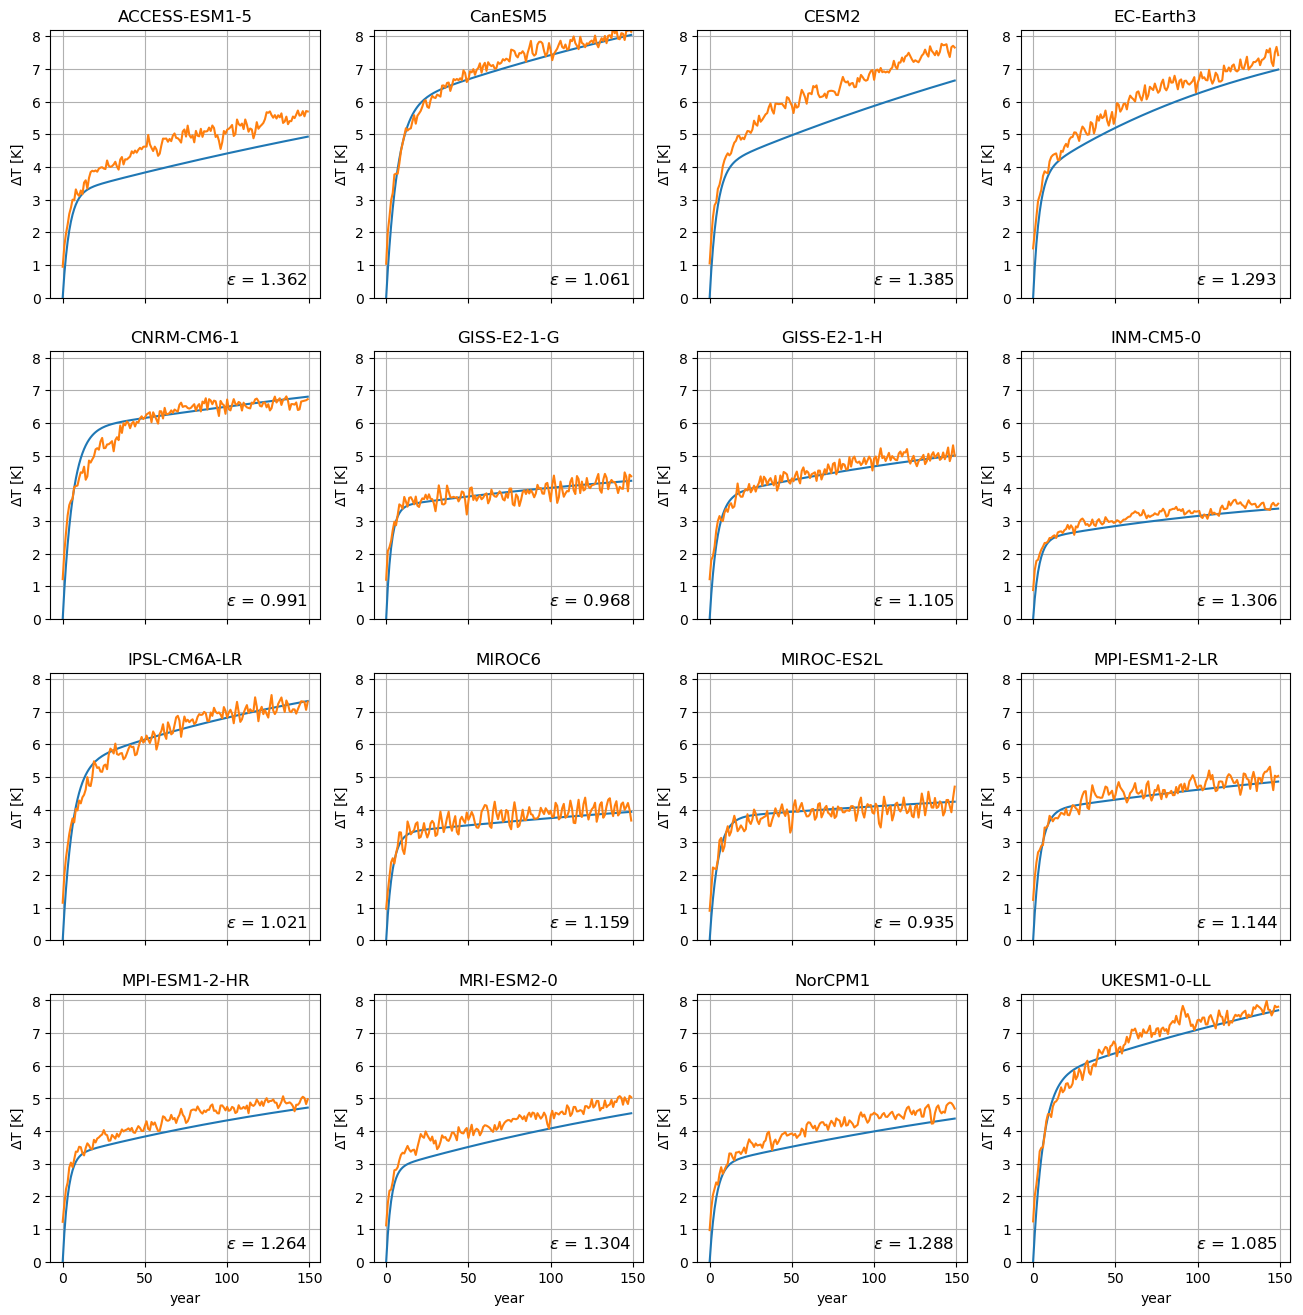

In [9]:
fig = plt.figure(figsize=(16, 16))
for n, name in enumerate(models):
    print(name)
    T = ddict[name]["abrupt-4xCO2"]["tas"] - ddict[name]["piControl"]["tas"]
    
    axs = fig.add_subplot(4, 4, n+1)
    T1_4x_dict[name].plot.line(x="time", ax=axs, add_legend=False)
    T.plot(ax=axs)
    axs.grid()
    axs.set_title(name)
    axs.set_ylabel("$\Delta$T [K]")
    axs.set_ylim(0, 8.2)
    
    axs.annotate(f"$\epsilon$ = {param_dict[name]['epsilon'].data[0]:5.3f}",
                 xy=(0.65, 0.05),
                 xycoords="axes fraction",
                 fontsize=12)
    
    if n < 12:
        axs.set_xticklabels([])
        axs.set_xlabel("")
        
#fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_4xCO2_"+model_eff+"_efficacy.png",
#            bbox_inches="tight", dpi=150, facecolor="white")

ACCESS-ESM1-5
CanESM5
CESM2
EC-Earth3
CNRM-CM6-1
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MIROC-ES2L
MPI-ESM1-2-LR
MPI-ESM1-2-HR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL


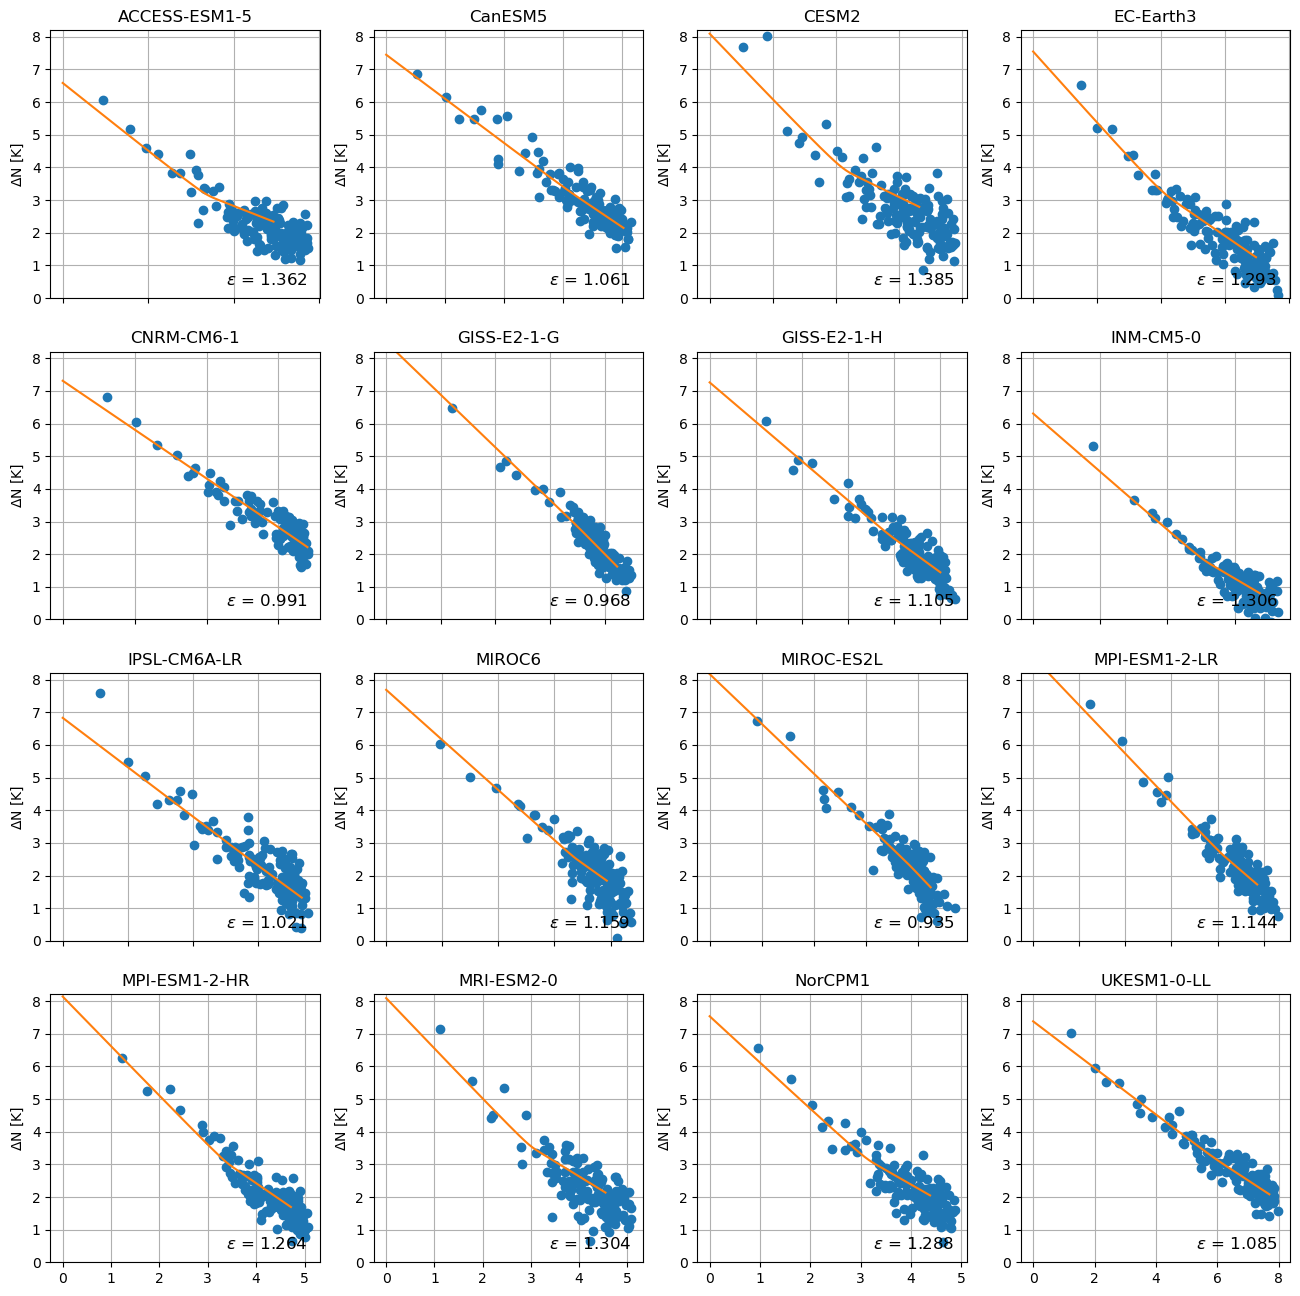

In [10]:
fig = plt.figure(figsize=(16, 16))
for n, name in enumerate(models):
    print(name)
    T = ddict[name]["abrupt-4xCO2"]["tas"] - ddict[name]["piControl"]["tas"]
    R = ddict[name]["abrupt-4xCO2"]["rtmt"] - ddict[name]["piControl"]["rtmt"]
    
    axs = fig.add_subplot(4, 4, n+1)
    axs.plot(T, R, "o", color="tab:blue")
    axs.plot(T1_4x_dict[name].squeeze(), N_4x_dict[name].squeeze(), color="tab:orange")
    axs.grid()
    axs.set_title(name)
    axs.set_ylabel("$\Delta$N [K]")
    axs.set_ylim(0, 8.2)
    
    axs.annotate(f"$\epsilon$ = {param_dict[name]['epsilon'].data[0]:5.3f}",
                 xy=(0.65, 0.05),
                 xycoords="axes fraction",
                 fontsize=12)
    
    if n < 12:
        axs.set_xticklabels([])
        axs.set_xlabel("")

### Plot two-layer model temperature response to Pinatubo

Text(0, 0.5, '$\\Delta$T [K]')

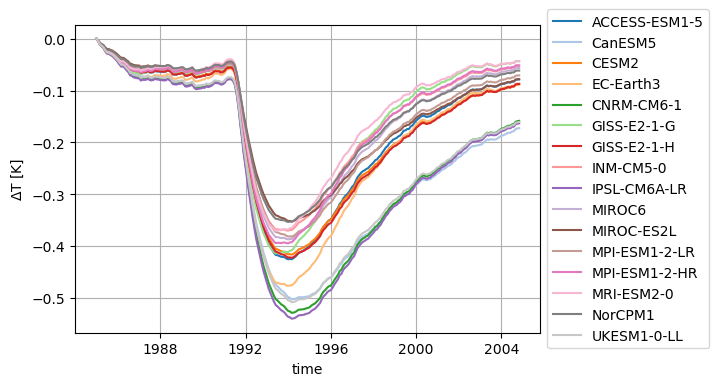

In [11]:
for n, name in enumerate(models):
    T1_volc_dict[name].plot(label=name, color=colors[n])
    
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.title("")
plt.ylabel("$\Delta$T [K]")

### Plot SW anomaly and OHU from two-layer model

Text(0.5, 0, '')

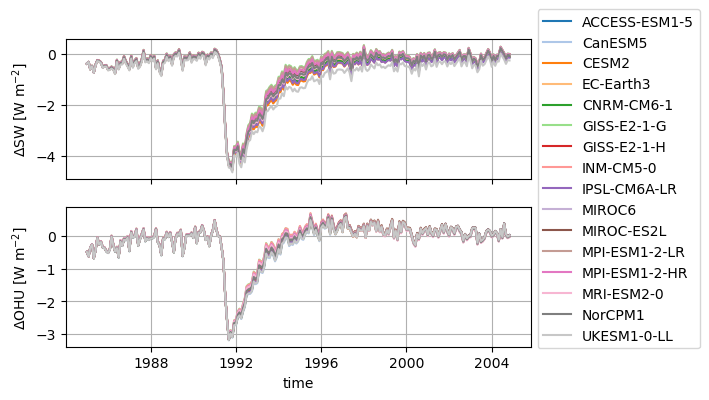

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
for n, name in enumerate(models):
    SW_dict[name].plot.line(x="time", label=name, ax=ax1, color=colors[n])
    
    Ndict[name].plot(label=name, ax=ax2, color=colors[n])
    
ax1.legend(loc="center left", bbox_to_anchor=(1.0, 0))
ax1.grid()
ax2.grid()
ax1.set_title("")
ax2.set_title("")
ax1.set_ylabel("$\Delta$SW [W m$^{-2}$]")
ax2.set_ylabel("$\Delta$OHU [W m$^{-2}$]")
ax1.set_xlabel("")

### Compute correlations

In [13]:
ratio_twolyr_arr = np.array([ratio[name].data[0] for name in models])
T1_twolyr_arr = np.array([T1_sum[name].data[0] for name in models])
sw_twolyr_arr = np.array([SW_sum[name].data[0] for name in models])

N_arr = np.array([float(Nint_dict[name].data) for name in models])

slope_t, intcpt_t, r_t, p_t, stderr_t = linregress(T1_twolyr_arr, N_arr)
slope_s, intcpt_s, r_s, p_s, stderr_s = linregress(sw_twolyr_arr, N_arr)
slope_r, intcpt_r, r_r, p_r, stderr_r = linregress(ratio_twolyr_arr, N_arr)

import pickle as pkl

out = {"slope": slope_r,
       "intcpt": intcpt_r,
       "r_value": r_r,
       "p_value": p_r,
       "std_err": stderr_r}

with open("integrate_ratio_OHU_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)

### Plot correlation between OHU and ratio in two-layer model

Text(0.85, 0.02, '$r^2=$0.406\n$p=$0.008')

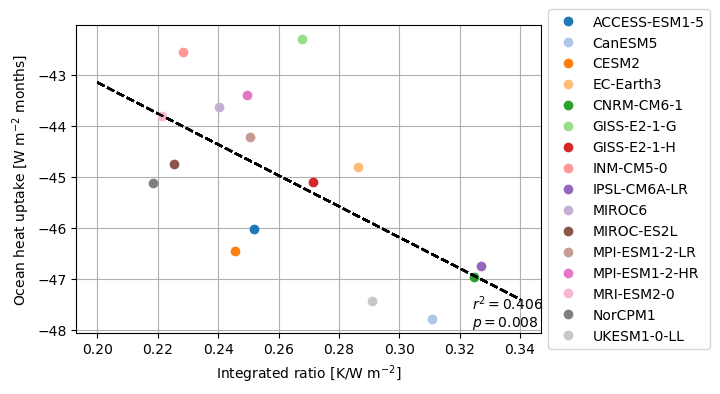

In [14]:
x = np.arange(0.2, 0.35, 0.01)
y = slope_r.data*x + intcpt_r.data

fig = plt.figure(1)
for n, name in enumerate(models):
    plt.plot(ratio[name], Nint_dict[name], "o", label=name, color=colors[n])
    plt.plot(x, y, "k--")
    
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid()
# plt.xlim(0.28, 0.47)

plt.xlabel("Integrated ratio [K/W m$^{-2}$]")
plt.ylabel("Ocean heat uptake [W m$^{-2}$ months]")

plt.annotate(f"$r^2=${r_r**2:5.3f}\n$p=${p_r:5.3f}",
             xy=(0.85, 0.02),
             xycoords="axes fraction")

#fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_OHU_vs_ratio.png",
#            bbox_inches="tight", dpi=150)

### Load ECS from Zelinka et al. data

In [17]:
import json

f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test

ACCESS-ESM1-5 = 3.8839034758064814
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
EC-Earth3 = 4.2600669989023405
CNRM-CM6-1 = 4.9036506204610255
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253567
MIROC6 = 2.601790969650521
MIROC-ES2L = 2.6605264351565174
MPI-ESM1-2-LR = 3.0254401947450527
MPI-ESM1-2-HR = 2.9797516932086876
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.0317257208870005
UKESM1-0-LL = 5.359162439690016


### Compute correlations with ECS

In [18]:
ecs_arr = np.array([ecs_dict[name] for name in models])

slope_ecs_t, intcpt_ecs_t, r_ecs_t, p_ecs_t, std_err_ecs_t = linregress(ecs_arr, T1_twolyr_arr)
slope_ecs_s, intcpt_ecs_s, r_ecs_s, p_ecs_s, std_err_ecs_s = linregress(ecs_arr, sw_twolyr_arr)
slope_ecs_r, intcpt_ecs_r, r_ecs_r, p_ecs_r, std_err_ecs_r = linregress(ecs_arr, ratio_twolyr_arr)

slope_ecs_n, intcpt_ecs_n, r_ecs_n, p_ecs_n, std_err_ecs_n = linregress(ecs_arr, N_arr)

print(f"Slope = {slope_ecs_r:5.3f}")
print(f"r = {r_ecs_r:5.3f}")
print(f"p = {p_ecs_r:5.3f}")

Slope = 0.022
r = 0.725
p = 0.001


### Plot correlations with integrated T, SW and ratio

Text(0, 0.5, 'ratio [K/W m$^{-2}$]')

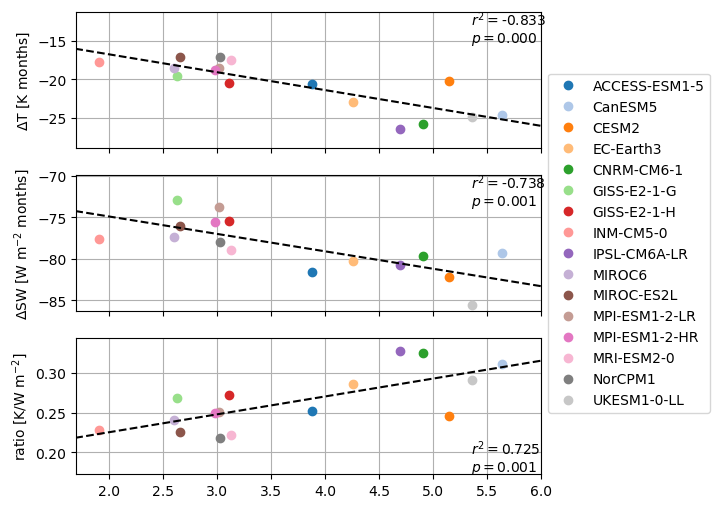

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

for n, name in enumerate(models):
    ax1.plot(ecs_dict[name], T1_sum[name], "o", color=colors[n], label=name)
    ax2.plot(ecs_dict[name], SW_sum[name], "o", color=colors[n], label=name)
    ax3.plot(ecs_dict[name], ratio[name], "o", color=colors[n], label=name)
    
x = np.arange(0, 7, 0.1)
y_T = slope_ecs_t*x + intcpt_ecs_t
y_sw = slope_ecs_s*x + intcpt_ecs_s
y_r = slope_ecs_r*x + intcpt_ecs_r

ax1.plot(x, y_T, "k--")
ax2.plot(x, y_sw, "k--")
ax3.plot(x, y_r, "k--")

ax1.set_xlim(1.7, 6)

ax1.annotate(f"$r^2=${r_ecs_t:5.3f}\n$p=${p_ecs_t:5.3f}",
             xy=(0.85, 0.78),
             xycoords="axes fraction")

ax2.annotate(f"$r^2=${r_ecs_s:5.3f}\n$p=${p_ecs_s:5.3f}",
             xy=(0.85, 0.78),
             xycoords="axes fraction")

ax3.annotate(f"$r^2=${r_ecs_r:5.3f}\n$p=${p_ecs_r:5.3f}",
             xy=(0.85, 0.02),
             xycoords="axes fraction")
    
ax1.grid()
ax2.grid()
ax3.grid()

ax2.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

ax1.set_ylabel("$\Delta$T [K months]")
ax2.set_ylabel("$\Delta$SW [W m$^{-2}$ months]")
ax3.set_ylabel("ratio [K/W m$^{-2}$]")

### Plot correlation between OHU and ECS

(1.7, 5.8)

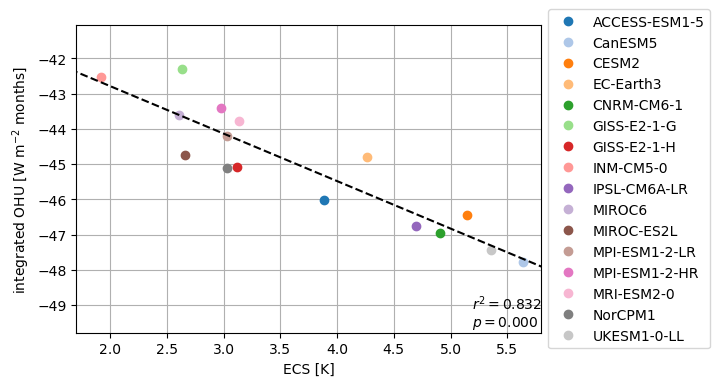

In [20]:
colors = pl.cm.tab20.colors
x = np.arange(1, 7, 0.1)

fig = plt.figure(1)
for n, name in enumerate(models):
    plt.plot(ecs_dict[name], Nint_dict[name], "o", color=colors[n], label=name)
    
plt.plot(x, slope_ecs_n*x+intcpt_ecs_n, "k--")

plt.annotate(f"$r^2=${r_ecs_n**2:5.3f}\n$p=${p_ecs_n:5.3f}",
             xy=(0.85, 0.02),
             xycoords="axes fraction")
    
plt.ylabel("integrated OHU [W m$^{-2}$ months]")
plt.xlabel("ECS [K]")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.xlim(1.7, 5.8)

#plt.savefig("../../../figures/volcano/2021/twolyr/twolyr_OHU_vs_ECS.png",
#            bbox_inches="tight", dpi=150)

### Plot combined figure like one from paper

Text(-0.06, 1.05, '(c)')

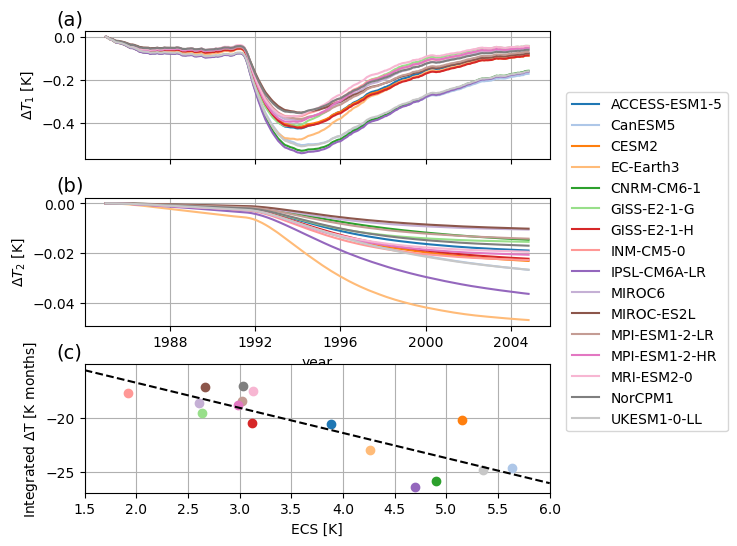

In [21]:
colors = pl.cm.tab20.colors

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

for n, name in enumerate(models):
    T1_volc_dict[name].plot(label=name, color=colors[n], ax=ax1)
    T2_volc_dict[name].plot(label=name, color=colors[n], ax=ax2)

ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

ax1.grid()
ax2.grid()

ax1.set_xticklabels("")

ax1.set_ylabel("$\Delta T_1$ [K]")
ax2.set_ylabel("$\Delta T_2$ [K]")
ax1.set_xlabel("")
ax2.set_xlabel("year")

for n, name in enumerate(models):
    ax3.plot(ecs_dict[name], T1_sum[name], "o", color=colors[n], label=name)

ax3.grid()
ax3.set_xlim(1.5, 6)

x = np.arange(1.5, 6.01, 0.1)
ax3.plot(x, slope_ecs_t*x + intcpt_ecs_t, "k--")


ax3.set_ylabel("Integrated $\Delta$T [K months]")
ax3.set_xlabel("ECS [K]")

ax1.set_title("")
ax2.set_title("")
ax3.set_title("")

fig.subplots_adjust(hspace=0.3)

ax1.annotate("(a)", xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=14)
ax2.annotate("(b)", xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=14)
ax3.annotate("(c)", xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=14)

### Serialize out ratio data

In [22]:
import pickle as pkl

with open("twolyr_variableepsilon_ratio.pkl", "wb") as f:
    pkl.dump(ratio, f)